In [21]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [22]:

# Load particle tracers
analogTracer3d: AnalogParticleTracer = pickle.load(open('data/analogTracer3d.pkl', 'rb'))
kdr3d = pickle.load(open('data/kdr3d.pkl', 'rb'))
kdr3dMS = pickle.load(open('data/kdrMS3d.pkl', 'rb'))

doseEstimatorK3d: DoseEstimator = pickle.load(open('data/doseEstimatorK3d.pkl', 'rb'))[0]
doseEstimatorKDR3d = pickle.load(open('data/doseEstimatorKDR3d.pkl', 'rb'))[0]
doseEstimatorKDRMS3d = pickle.load(open('data/doseEstimatorKDRMS3d.pkl', 'rb'))[0]

simDomain: LungSimulationDomain = analogTracer3d.simDomain
simOptions: LungInitialConditions = analogTracer3d.simOptions
bins = simDomain.xbins
width = simDomain.width

/tmp/ipykernel_9308/4164234772.py:2: DeprecationWarning: Please use `RegularGridInterpolator` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  analogTracer3d: AnalogParticleTracer = pickle.load(open('data/analogTracer3d.pkl', 'rb'))
/tmp/ipykernel_9308/4164234772.py:3: DeprecationWarning: Please use `RegularGridInterpolator` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  kdr3d = pickle.load(open('data/kdr3d.pkl', 'rb'))
/tmp/ipykernel_9308/4164234772.py:4: DeprecationWarning: Please use `RegularGridInterpolator` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  kdr3dMS = pickle.load(open('data/kdrMS3d.pkl', 'rb'))


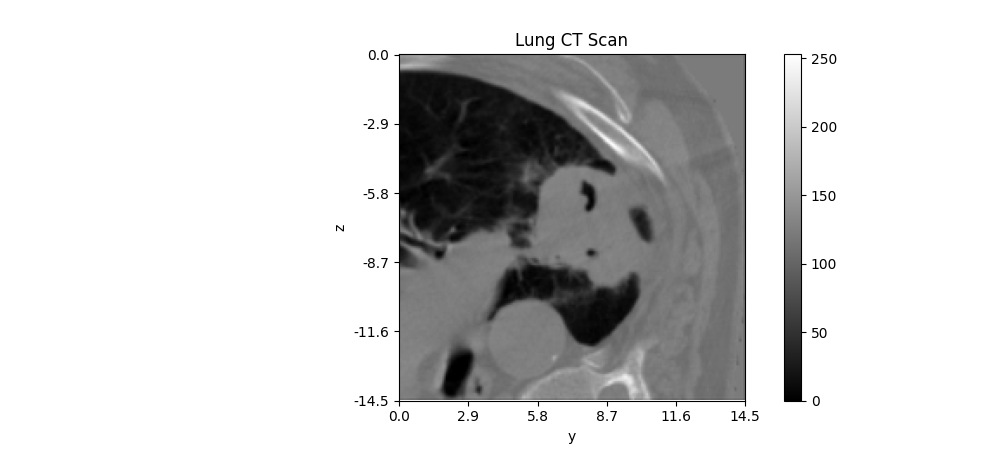

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 4.5))
pos = ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray')  # type: ignore
ax1.set_title('Lung CT Scan')
ax1.set_xlabel('y')
ax1.set_ylabel('z')
nticks = 6
ax1.set_xticks(np.linspace(0, bins, nticks))
ax1.set_xticklabels(np.linspace(0, width, nticks))
ax1.set_yticks(np.linspace(0, bins, nticks))
ax1.set_yticklabels(np.linspace(0, -width, nticks))
fig.colorbar(pos, ax=ax1)


In [24]:
xBins = np.linspace(0, width, bins+1)
yBins = np.linspace(-width, 0, bins+1)

energyDepositionK3d_ERE = np.flipud(np.reshape(doseEstimatorK3d.scoreMatrix, (bins, bins)))
energyDepositionKDRMS3d_ERE = np.flipud(np.reshape(doseEstimatorKDRMS3d.scoreMatrix, (bins, bins)))
energyDepositionKDR3d_ERE = np.flipud(np.reshape(doseEstimatorKDR3d.scoreMatrix, (bins, bins)))


/tmp/ipykernel_9308/3733536262.py:9: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
/tmp/ipykernel_9308/3733536262.py:13: RuntimeWarning: divide by zero encountered in log
  ax2.contourf(X, Y, np.log(energyDepositionKDR3d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')
/tmp/ipykernel_9308/3733536262.py:17: RuntimeWarning: divide by zero encountered in log
  ax3.contourf(X, Y, np.log(energyDepositionKDRMS3d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')


Text(0.5, 1.0, '3d KDR MS simulation')

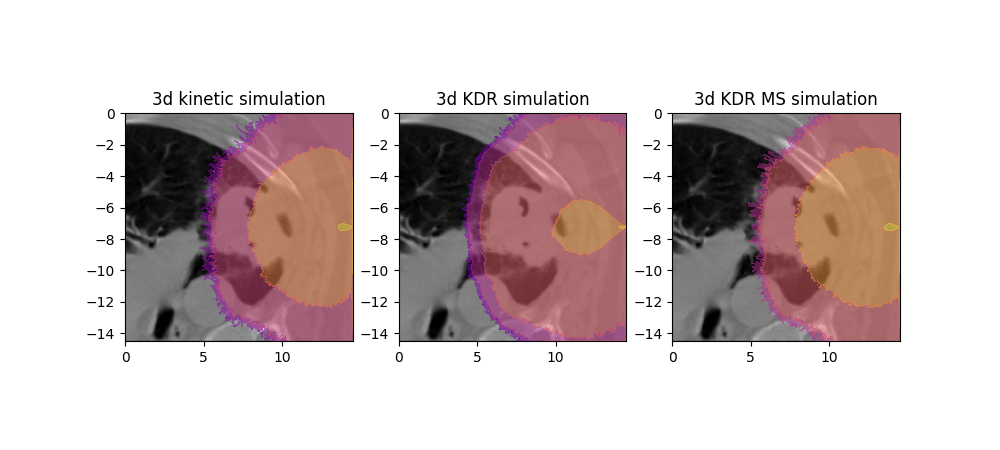

In [31]:
extent = [xBins.min(), xBins.max(), yBins.min(), yBins.max()]
xBins1 = np.linspace(0, width, bins)
yBins1 = np.linspace(-width, 0, bins)
X, Y = np.meshgrid(xBins1, yBins1)
levels = 4

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4.5))
ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax1.set_title('3d kinetic simulation')

ax2.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax2.contourf(X, Y, np.log(energyDepositionKDR3d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')
ax2.set_title('3d KDR simulation')

ax3.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax3.contourf(X, Y, np.log(energyDepositionKDRMS3d_ERE), alpha=0.5, extent=extent, levels=levels, cmap='plasma')
ax3.set_title('3d KDR MS simulation')



/tmp/ipykernel_9308/2068088755.py:3: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)


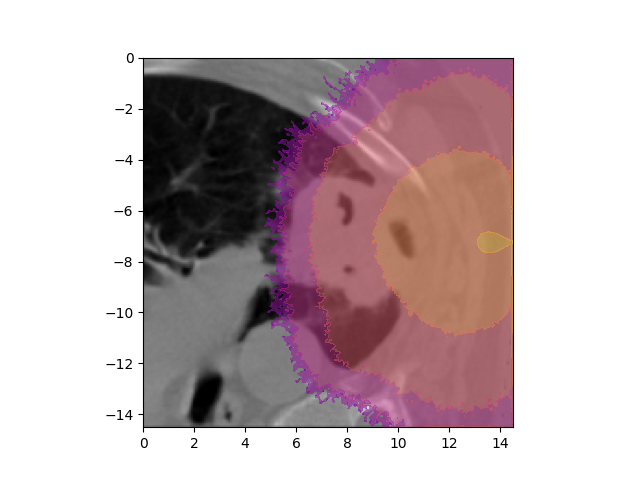

In [26]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
fig.savefig('figures/KDRLungK.pdf')

/tmp/ipykernel_9308/2956221868.py:3: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionKDR3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)


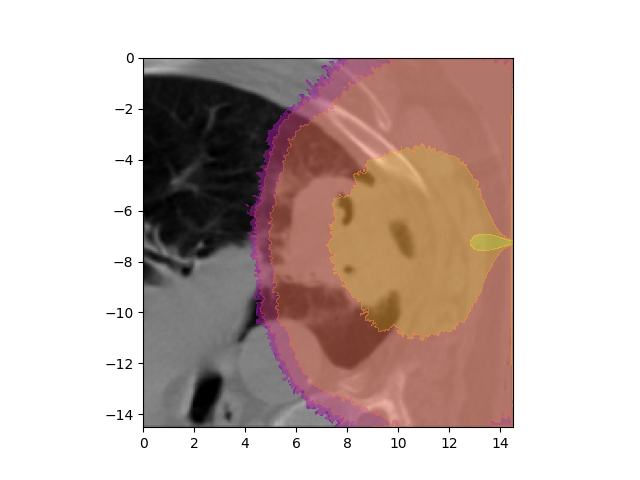

In [27]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionKDR3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
fig.savefig('figures/KDRLungKDR.pdf')

/tmp/ipykernel_9308/1997168427.py:3: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionKDRMS3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)


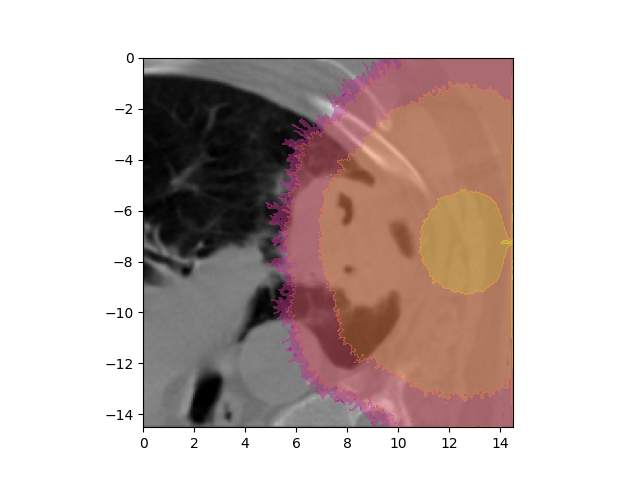

In [28]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionKDRMS3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
fig.savefig('figures/KDRLungKDRMS.pdf')

### Initial direction

In [29]:
testInit = LungInitialConditions(kappa=5000)
N = 1000

# Sample a lot of initial vectors
vecs = np.empty((N, 3), dtype=float)
for i in range(N):
    vecs[i, :] = testInit.initialDirection()


(-1.0, 1.0)

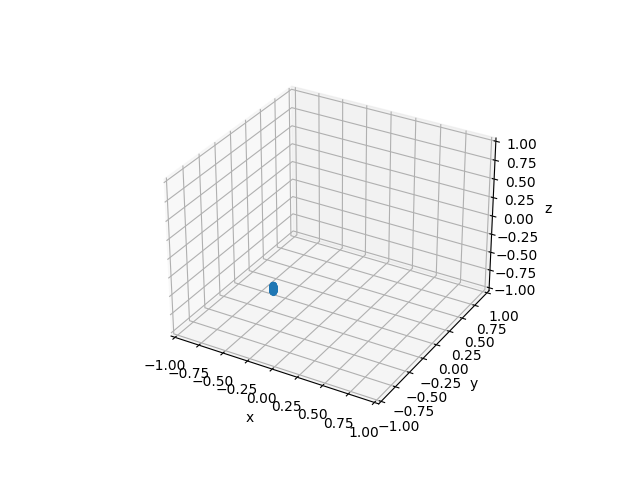

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])